# Preparacion de los datos

In [201]:
# Bibliotecas para Manipulación de Datos y Análisis
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import sqlite3

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
# Operaciones del sistema operativo
import os
# Preprocesamiento y Escalado
# Preprocesamiento y Escalado
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, RobustScaler, StandardScaler

In [202]:
# Configuro los parámetros iniciales de matplotlib para estandarizar los gráficos
params = {
    'figure.figsize': (16, 10),  # Establezco el tamaño de cada gráfico
    'figure.dpi': 80,  # Configuro la resolución por pulgada
    'figure.facecolor': 'white',  # Defino el color de fondo
    'figure.edgecolor': 'white',  # Defino el color del borde
    'figure.frameon': True,  # Mantengo el borde del gráfico activado
    'figure.constrained_layout.use': False,  # Desactivo el diseño restringido para las figuras
    'figure.constrained_layout.h_pad': 0.04167,  # Espaciado horizontal en el diseño restringido
    'figure.constrained_layout.w_pad': 0.04167,  # Espaciado vertical en el diseño restringido
    'axes.labelsize': 12,  # Establezco el tamaño de las etiquetas de los ejes
    'axes.titlesize': 14,  # Establezco el tamaño del título
    'axes.labelweight': 'normal',  # Configuro el grosor de la fuente de las etiquetas
    'xtick.labelsize': 10,  # Defino el tamaño de las etiquetas del eje x
    'ytick.labelsize': 10,  # Defino el tamaño de las etiquetas del eje y
    'xtick.color': 'black',  # Configuro el color de las etiquetas del eje x
    'ytick.color': 'black',  # Configuro el color de las etiquetas del eje y
    'axes.spines.top': True,  # Mantengo visible el borde superior del gráfico
    'axes.spines.right': True,  # Mantengo visible el borde derecho del gráfico
    'legend.frameon': True,  # Mantengo visible el marco de la leyenda
    'grid.linestyle': '-',  # Defino el estilo de las líneas de la cuadrícula
    'grid.linewidth': 0.8,  # Configuro el grosor de las líneas de la cuadrícula
    'grid.color': 'gray',  # Establezco el color de las líneas de la cuadrícula
    'legend.fontsize': 10,  # Configuro el tamaño de la fuente de la leyenda
    'axes.titleweight': 'normal',  # Establezco el grosor de la fuente del título
    'axes.titlecolor': 'black',  # Configuro el color del título
    'axes.titlelocation': 'center',  # Coloco el título en el centro del gráfico
}

# Actualizo los parámetros de Matplotlib con la configuración establecida
plt.rcParams.update(params)

# Aplico el tema de tableau
plt.style.use('tableau-colorblind10')

# Activo la visualización de gráficos en línea (dentro de la celda de código)
%matplotlib inline

In [203]:
def create_table_ddl(df, table_name, pk='', fk={}):
    ddl = f"CREATE TABLE {table_name} (\n"
    
    # Definir los tipos de datos SQL
    dtype_mapping = {
        'int64': 'INTEGER',
        'float64': 'REAL',
        'datetime64[ns]': 'TIMESTAMP',
        'object': 'TEXT'  # Por defecto para tipos de objeto (cadenas de texto)
    }
    
    # Agregar columnas
    for column, dtype in zip(df.columns, df.dtypes):
        sql_dtype = dtype_mapping.get(str(dtype), 'TEXT')  # Usar 'TEXT' por defecto
        if column == pk:
            ddl += f"    {column} {sql_dtype} PRIMARY KEY AUTOINCREMENT,\n"
        else:
            ddl += f"    {column} {sql_dtype},\n"
    
    # Agregar claves foráneas
    for fk_column, (ref_table, ref_column) in fk.items():
        ddl += f"    FOREIGN KEY ({fk_column}) REFERENCES {ref_table} ({ref_column}),\n"
    
    # Eliminar la última coma y añadir el cierre de la tabla
    ddl = ddl.rstrip(',\n') + "\n);"
    
    return ddl

## Lectura de csv

In [204]:
df_path = '../data/bronze/df_from_zip.csv'
df = pd.read_csv(df_path)
# creo una copia del dataframe original que almacenare en un nuevo df de procesamiento
df_procesado = df.copy()

## Limpieza

### Valores nulos

Deteccion y visualizacion

In [205]:
# lista con convenciones de valores nulos en strings
common_na_strings = ["faltante", "NA", "N A", "N/A", "#N/A", "NA ", " NA", "N /A", "N / A", " N / A",
                     "N / A ", "na", "n a", "n/a", "na "," na", "n /a", "n / a", " a / a", "n / a ",
                     "NULO", "nulo", "", "?", "*", ".", " ",
                     "MISSING", "Missing", "missing", "NULL", "null", "Null", "none", "None", "NONE",
                     "NaN", "nan", "NAN", "UNDEFINED", "undefined", "Undefined", "---", "-999", "-9999", "unknown"]

In [206]:
# remplazo las posibles convenciones de valores nulos dentro del dataframe, por valores nulos np.nan detectados por numpy
df_procesado = df_procesado.replace(
    to_replace=common_na_strings,
    value=np.nan
)

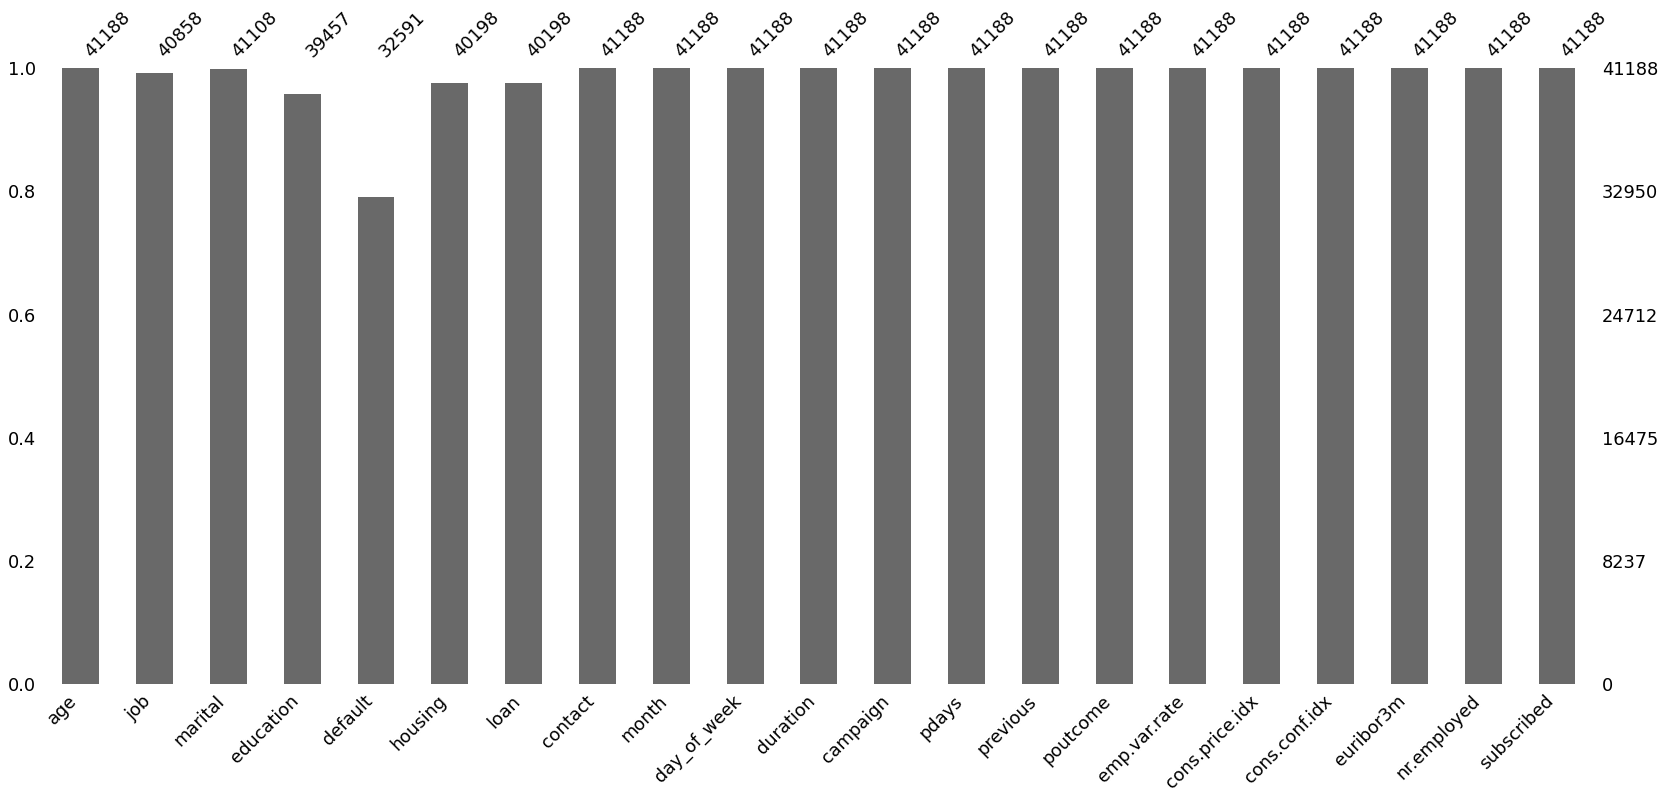

In [207]:
msno.bar(df_procesado)
plt.show()

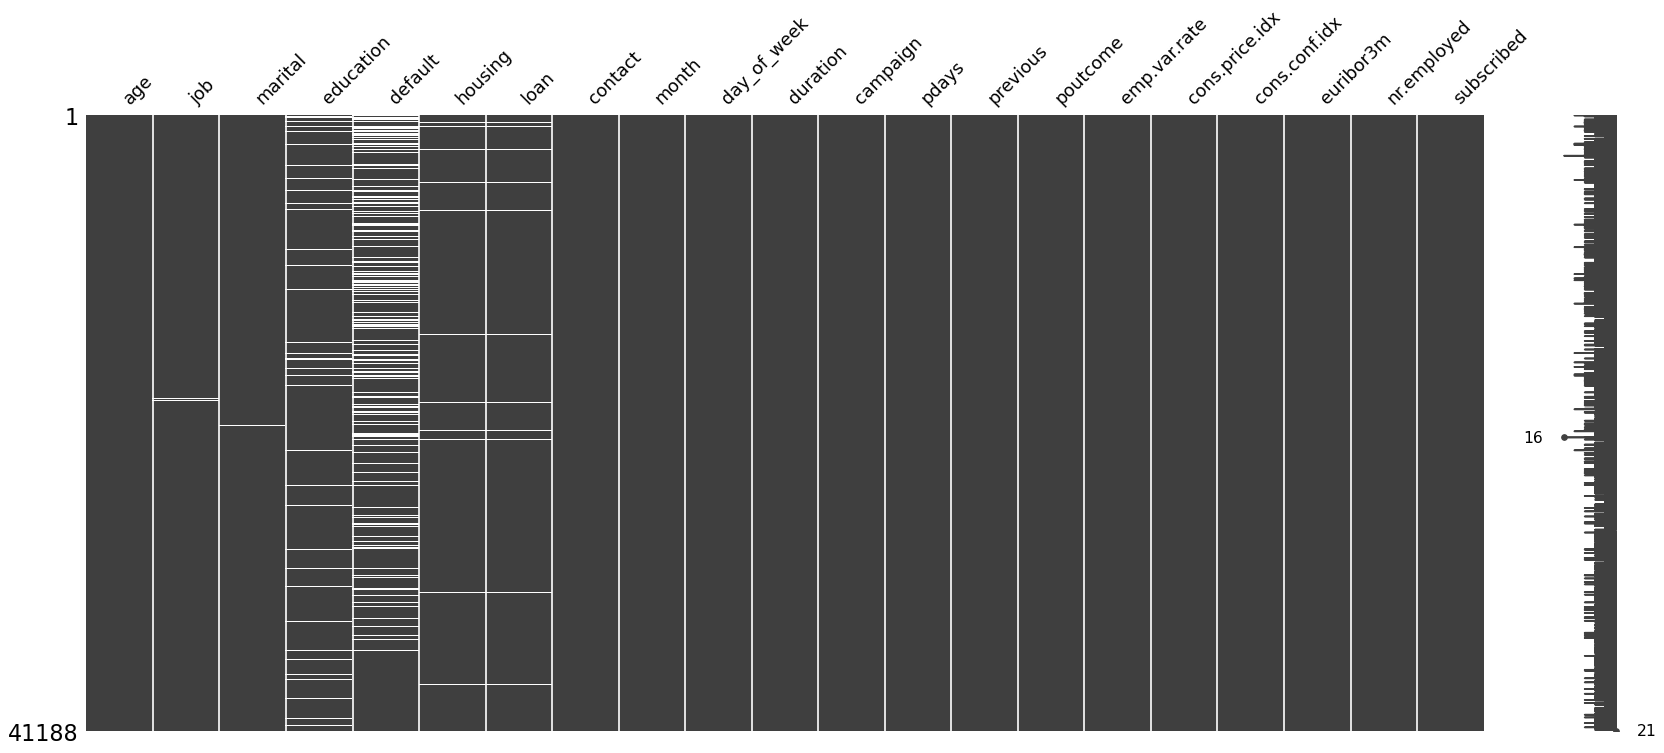

In [208]:
msno.matrix(df_procesado)
plt.show()

Imputacion


In [209]:
# variables a imputar por unknown para evitar generar ruido dado la sensivilidad de los datos categoricos
imputer = SimpleImputer(strategy='constant', fill_value='unknown')

df_procesado['poutcome'] = imputer.fit_transform(df_procesado[['poutcome']]).ravel()
df_procesado['default'] = imputer.fit_transform(df_procesado[['default']]).ravel()
df_procesado['loan'] = imputer.fit_transform(df_procesado[['loan']]).ravel()
df_procesado['housing'] = imputer.fit_transform(df_procesado[['housing']]).ravel()

In [210]:
# selecciono las columnas a imputar por la moda dado que son columnas con datos categoricos no tan sensibles
# Imputación por la moda para la columna 'job'
imputer = SimpleImputer(strategy='most_frequent')
df_procesado['job'] = imputer.fit_transform(df_procesado[['job']]).ravel()
# Imputación por la moda para la columna 'marital'
df_procesado['marital'] = imputer.fit_transform(df_procesado[['marital']]).ravel()
# Imputación por la moda para la columna 'education'
df_procesado['education'] = imputer.fit_transform(df_procesado[['education']]).ravel()

In [211]:
#Compruebo que la imputacion se realizo correctamente (en el caso de la columna contact pienso eliminarla luego)
df_procesado.isnull().sum().sum()

0

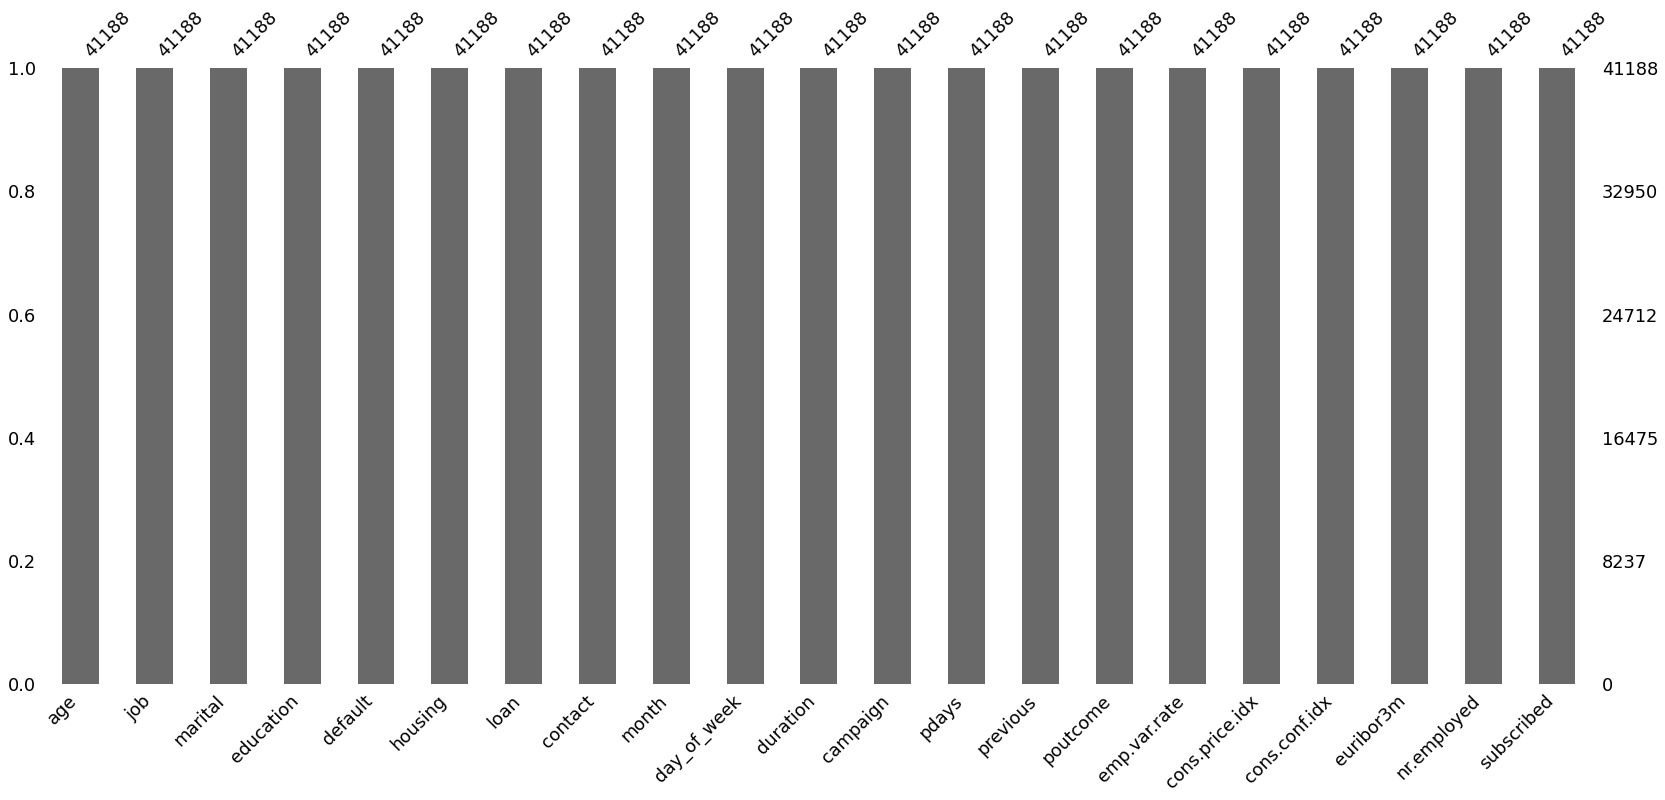

In [212]:
msno.bar(df_procesado)
plt.show()

### Obvervacion de esta sub-etapa:

Los valores nulos están distribuidos de manera desigual entre las distintas columnas del conjunto de datos. Sin embargo, las columnas housing y loan presentan una correlación significativa en cuanto a la presencia de valores nulos. Esto es comprensible, ya que la falta de información sobre **el préstamo de vivienda (housing) frecuentemente coincide con la ausencia de datos sobre el préstamo personal (loan), lo que refleja la relación lógica entre estos dos atributos.**

## Ingenieria de caracteristicas

### Seleccion de caracteristicas

In [213]:
df_procesado.sample(4)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,subscribed
14659,43,blue-collar,married,basic.6y,no,no,yes,cellular,jul,tue,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1,no
32769,34,technician,married,basic.9y,no,no,no,cellular,may,mon,...,1,999,0,nonexistent,-1.8,92.893,-46.2,1.299,5099.1,no
750,30,services,divorced,basic.9y,no,no,yes,telephone,may,tue,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1114,54,admin.,divorced,university.degree,no,no,no,telephone,may,wed,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,yes


In [214]:
# Selecciono aquellas columnas que no aportan valor a la situacion de negocio

# contact: tipo de comunicación del contacto (categórico: ‘cellular’, ‘telephone’)
# pdays: número de días que han pasado desde que el cliente fue contactado por última vez en una campaña anterior (numérico; 999 significa que el cliente no fue contactado previamente)
# euribor3m: tasa euribor a 3 meses - indicador diario (numérico)
# nr.employed: número de empleados - indicador trimestral (numérico)
# duration: duración del último contacto, en segundos (numérico)

columnas_a_eliminar = ['contact', 'duration', 'pdays', 'nr.employed', 'euribor3m']
df_procesado.drop(columns=columnas_a_eliminar, inplace=True)

In [215]:
# agrego columna 'id' para identificar cada evento

df_procesado['id'] = range(1, len(df_procesado) + 1)

### Estandarizacion de tipos de datos

In [216]:
df_procesado.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
month              object
day_of_week        object
campaign            int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
subscribed         object
id                  int64
dtype: object

In [217]:
# selecciono las columnas no numericas
columnas_no_numericas = df_procesado.select_dtypes(exclude=['number']).columns

# creo un diccionario con los valores unicos por columa y otro con la cantidad de valores unicos por columna
valores_unicos_por_columna = df_procesado[columnas_no_numericas].apply(lambda x: x.unique())
cantidad_valores_unicos_col = {col: len(valores_unicos_por_columna[col]) for col in valores_unicos_por_columna.index}

In [218]:
print(valores_unicos_por_columna)

job            [housemaid, services, admin., blue-collar, tec...
marital                              [married, single, divorced]
education      [basic.4y, high.school, basic.6y, basic.9y, pr...
default                                       [no, unknown, yes]
housing                                       [no, yes, unknown]
loan                                          [no, yes, unknown]
month          [may, jun, jul, aug, oct, nov, dec, mar, apr, ...
day_of_week                            [mon, tue, wed, thu, fri]
poutcome                         [nonexistent, failure, success]
subscribed                                             [no, yes]
dtype: object


In [219]:
valores_unicos_por_columna.index

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'month',
       'day_of_week', 'poutcome', 'subscribed'],
      dtype='object')

In [220]:
print(cantidad_valores_unicos_col)

{'job': 11, 'marital': 3, 'education': 7, 'default': 3, 'housing': 3, 'loan': 3, 'month': 10, 'day_of_week': 5, 'poutcome': 3, 'subscribed': 2}


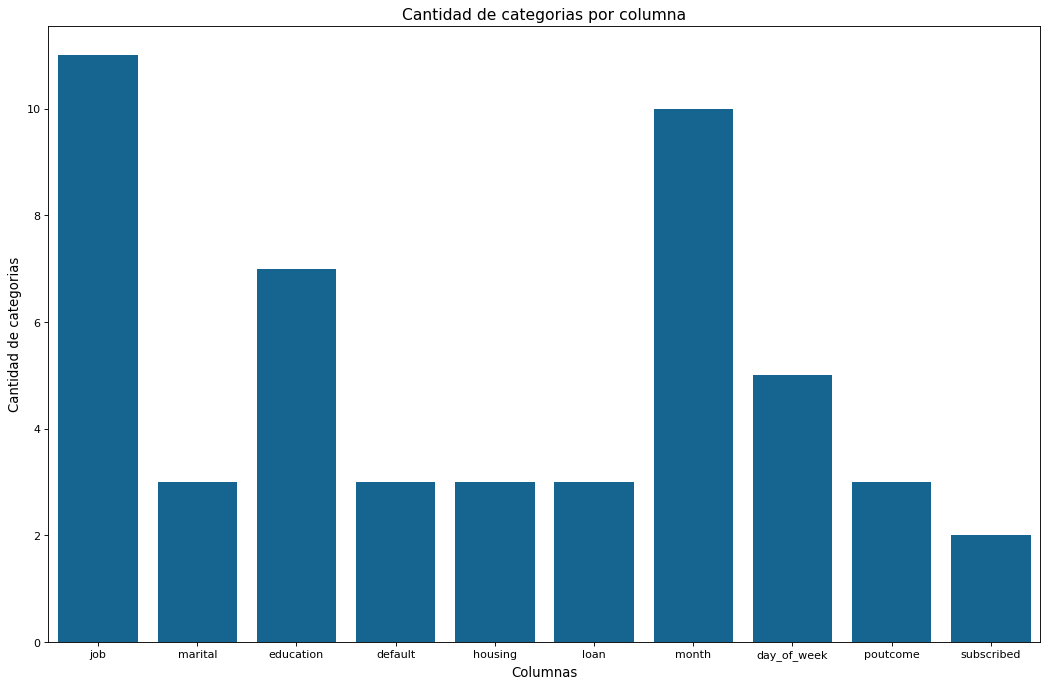

In [221]:
sns.barplot(data=cantidad_valores_unicos_col)
plt.title('Cantidad de categorias por columna')
plt.xlabel('Columnas')
plt.ylabel('Cantidad de categorias')
plt.show()

In [222]:
# separo dos listas para las variables categoricas, uno con las nominales y otro con las ordinales
columnas_categoricas_ordinales = ['marital', 'education', 'default', 'housing', 'loan', 'month', 'poutcome', 'subscribed']
columnas_categoricas_nominales = ['job']
# creo una lista que unifica las variables categoricas ordinales y nominales dentro de una sola
columnas_categoricas = columnas_categoricas_ordinales + columnas_categoricas_nominales

In [223]:
# transformo el tipo de datos de las columnas categoricas a 'category'
df_procesado[columnas_categoricas] = df_procesado[columnas_categoricas].astype('category')

In [224]:
# transformo el tipo de dato de la columna "month" a su correspondiente
df_procesado['month'] = pd.to_datetime(df_procesado['month'], format='%b').dt.month

### Codificacion de datos

Variables categoricas ordinales

In [225]:
df_variables_ordinales_escaladas = pd.DataFrame({})

In [226]:
# Definir un diccionario con las categorías en orden
categorias_ordenadas = {
    'marital': ['unknown', 'single', 'married', 'divorced'],
    'education': ['unknown', 'basic.4y', 'basic.6y', 'basic.9y', 'primary', 'high.school', 'secondary', 'illiterate', 'professional.course', 'tertiary', 'university.degree', np.nan],
    'default': ['unknown', 'no', 'yes'],
    'housing': ['unknown', 'no', 'yes'],
    'loan': ['unknown', 'no', 'yes'],
    'poutcome': ['other', 'failure', 'nonexistent', 'success', np.nan],
    'subscribed': ['no', 'yes'],
    'month': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'],
}

# Configurar el codificador con las categorías en el orden especificado
ordinal_encoder = OrdinalEncoder(categories=list(categorias_ordenadas.values()))

# Aplicar el codificador a las columnas y asignar los resultados a nuevas columnas
columnas_codificadas = [f"{col}_encoded" for col in categorias_ordenadas.keys()]
df_variables_ordinales_escaladas[columnas_codificadas] = ordinal_encoder.fit_transform(df_procesado[list(categorias_ordenadas.keys())])

In [227]:
df_variables_ordinales_escaladas.sample(2)

,marital_encoded,education_encoded,default_encoded,housing_encoded,loan_encoded,poutcome_encoded,subscribed_encoded,month_encoded
32390,2.0,8.0,1.0,1.0,1.0,1.0,0.0,4.0
1892,2.0,10.0,1.0,1.0,1.0,2.0,0.0,4.0


Variables categoricas nominales

In [228]:
df_variables_nominales_escaladas = pd.DataFrame({}, columns=columnas_categoricas_nominales)

In [229]:
# Inicializar el codificador
label_encoders = {col: LabelEncoder() for col in columnas_categoricas_nominales}

# Aplicar el codificador a las columnas nominales
for col in columnas_categoricas_nominales:
    df_variables_nominales_escaladas[col] = label_encoders[col].fit_transform(df_procesado[col])

In [230]:
df_variables_nominales_escaladas.sample(2)

,job
23714,5
28238,9


### Escalamiento de datos

In [231]:
df_columnas_numericas = df_procesado.select_dtypes(include=['number'])

In [232]:
# Escalar las variables numéricas
scaler = RobustScaler()
variables_numericas_escaladas = scaler.fit_transform(df_columnas_numericas)
df_numerico_escalado = pd.DataFrame(variables_numericas_escaladas, columns=df_columnas_numericas.columns)

In [233]:
# Concatenar los DataFrames
df_estandarizado_escalado = pd.concat([df_numerico_escalado, df_variables_ordinales_escaladas, df_variables_nominales_escaladas], axis=1)

# Crear el diccionario de renombramiento
nombres_actuales = df_estandarizado_escalado.columns
nuevos_nombres = (df_numerico_escalado.columns.tolist() +
                   df_variables_ordinales_escaladas.columns.tolist() +
                   df_variables_nominales_escaladas.columns.tolist())
renombramiento = dict(zip(nombres_actuales, nuevos_nombres))

df_estandarizado_escalado.rename(columns=renombramiento, inplace=True)

In [234]:
df_estandarizado_escalado.sample(2)

,age,month,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,id,marital_encoded,education_encoded,default_encoded,housing_encoded,loan_encoded,poutcome_encoded,subscribed_encoded,month_encoded,job
6815,-0.2,-0.333333,0.0,0.0,0.0,0.266594,0.857143,-0.669070,3.0,5.0,1.0,1.0,2.0,2.0,0.0,4.0,7
1854,1.2,-0.333333,-0.5,0.0,0.0,0.266594,0.857143,-0.909972,2.0,1.0,0.0,1.0,1.0,2.0,0.0,4.0,1


### Modelado OLAP para BI

![Imagen modelo OLAP](../data/silver/modelado_olap.png)

Identifico 3 tablas de hechos, sus tablas dimensionales y sub tablas dimensionales: 

1. ft_marketing_campaign:
- dim_contact
- dim_months
- dim_days
- dim_poutcome.
- dim_clients
    - sub_dim_jobs, 
    - sub_div_marital_status
    - sub_dim_education
    - sub_dim_default_status
    - sub_dim_housing_status
    - sub_dim_loan_status

2. ft_subscriptions
- dim_clients
    - sub_dim_jobs, 
    - sub_div_marital_status
    - sub_dim_education
    - sub_dim_default_status
    - sub_dim_housing_status
    - sub_dim_loan_status

3. ft_social_economical_context 



**Creacion de df de tablas sub dimensionales**

In [235]:
# Conectar a la base de datos
conn = sqlite3.connect('private_bank_mkt.db')

# Crear un cursor para ejecutar comandos SQL
cursor = conn.cursor()

# Habilitar las claves foráneas
cursor.execute("PRAGMA foreign_keys = ON;")

In [236]:
# Tabla sub dimensional: jobs

sub_dim_jobs = df_procesado[['job']].drop_duplicates().reset_index(drop=True)
sub_dim_jobs['job_id'] = range(1, len(sub_dim_jobs) + 1)

In [237]:
# Tabla sub dimensional: marital_status

sub_dim_marital_status = df_procesado[['marital']].drop_duplicates().reset_index(drop=True)
sub_dim_marital_status['marital_id'] = range(1, len(sub_dim_marital_status) + 1)

In [238]:
# Tabla sub dimensional: education

sub_dim_education = df_procesado[['education']].drop_duplicates().reset_index(drop=True)
sub_dim_education['education_id'] = range(1, len(sub_dim_education) + 1)

In [239]:
# Tabla sub dimensional: default_status

sub_dim_default_status = df_procesado[['default']].drop_duplicates().reset_index(drop=True)
sub_dim_default_status['default_id'] = range(1, len(sub_dim_default_status) + 1)

In [240]:
# Tabal sub dimensional: housing_status

sub_dim_housing_status = df_procesado[['housing']].drop_duplicates().reset_index(drop=True)
sub_dim_housing_status['housing_id'] = range(1, len(sub_dim_housing_status) + 1)

In [241]:
# Tabla sub dimensional: loan_status

sub_dim_loan_status = df_procesado[['loan']].drop_duplicates().reset_index(drop=True)
sub_dim_loan_status['loan_id'] = range(1, len(sub_dim_loan_status) + 1)

In [242]:
# Tabla sub dimensional: months

sub_dim_months = df_procesado[['month']].drop_duplicates().reset_index(drop=True)
sub_dim_months['month_id'] = range(1, len(sub_dim_months) + 1)

In [243]:
# Tabla sub dimensional: days

sub_dim_days = df_procesado[['day_of_week']].drop_duplicates().reset_index(drop=True)
sub_dim_days['day_of_week_id'] = range(1, len(sub_dim_days) + 1)

In [244]:
# Tabla sub dimensional: poutcome

sub_dim_poutcome = df_procesado[['poutcome']].drop_duplicates().reset_index(drop=True)
sub_dim_poutcome['poutcome_id'] = range(1, len(sub_dim_poutcome) + 1)

**Creacion de df de tablas dimensionales**

In [245]:
# tabla dimensional clients 

dim_clients = df_procesado[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan']].copy()

# Opcionalmente, si necesitas IDs únicos para cada cliente:
dim_clients['customer_id'] = range(1, len(dim_clients) + 1)

dim_clients = dim_clients.merge(sub_dim_jobs, on='job', how='left')
dim_clients = dim_clients.merge(sub_dim_marital_status, on='marital', how='left')
dim_clients = dim_clients.merge(sub_dim_education, on='education', how='left')
dim_clients = dim_clients.merge(sub_dim_default_status, on='default', how='left')
dim_clients = dim_clients.merge(sub_dim_housing_status, on='housing', how='left')
dim_clients = dim_clients.merge(sub_dim_loan_status, on='loan', how='left')

dim_clients = dim_clients[['age', 'customer_id', 'job_id', 'marital_id', 'education_id', 'default_id','housing_id', 'loan_id']]

# Eliminación de duplicados en caso de ser necesario
dim_clients = dim_clients.drop_duplicates().reset_index(drop=True)

**Cracion de df de fact tables**

In [246]:
# Tabla de hechos: campaign
# Seleccionamos solo las columnas necesarias
ft_campaign = df_procesado[['month', 'day_of_week', 'campaign', 'previous', 'poutcome', 'month', 'day_of_week', 'poutcome']].copy()
ft_campaign['campaign_id'] = range(1, len(ft_campaign)+1)

# Vinculamos con IDs de las tablas dimensionales
ft_campaign = pd.concat([ft_campaign, dim_clients['customer_id']], axis=1)
ft_campaign = ft_campaign.merge(sub_dim_months, on='month', how='left')
ft_campaign = ft_campaign.merge(sub_dim_days, on='day_of_week', how='left')
ft_campaign = ft_campaign.merge(sub_dim_poutcome, on='poutcome', how='left')

ft_campaign = ft_campaign[['campaign_id', 'job_id', 'marital_id', 'education_id', 'default_id', 'housing_id', 'loan_id', 'month_id', 'day_of_week_id', 'campaign', 'previous', 'poutcome_id']]

ft_campaign = ft_campaign.drop_duplicates().reset_index(drop=True)

ValueError: The column label 'month' is not unique.

In [ ]:
# tabla de hechos: social context

ft_context = df_procesado[['emp.var.rate', 'cons.price.idx', 'cons.conf.idx']].drop_duplicates().reset_index(drop=True)
ft_context['context_id'] = range(1, len(ft_context) + 1)

In [ ]:
# tabla de hechos: subscription

ft_subscription = df_procesado[['subscribed']].copy()
ft_subscription['subscription_id'] = range(1, len(ft_subscription) + 1)
ft_subscription = pd.concat([ft_subscription, dim_clients['customer_id']], axis=1)

In [ ]:
#def create_table_ddl(df, table_name, pk='', fk={}):

In [248]:
# Queries ddl sub dims
query_ddl_sub_dim_jobs = create_table_ddl(df=sub_dim_jobs,table_name= 'sub_dim_jobs',pk='job_id')
query_ddl_sub_dim_marital_status = create_table_ddl(df=sub_dim_marital_status, table_name='sub_dim_marital_status', pk='marital_id')
query_ddl_sub_dim_education = create_table_ddl(df=sub_dim_education, table_name='sub_dim_education', pk='education_id')
query_ddl_sub_dim_default_status = create_table_ddl(df=sub_dim_default_status, table_name='sub_dim_default_status', pk='default_id')
query_ddl_sub_dim_housing_status = create_table_ddl(df=sub_dim_housing_status, table_name='sub_dim_housing_status', pk='housing_id')
query_ddl_sub_dim_loan_status = create_table_ddl(df=sub_dim_loan_status, table_name='sub_dim_loan_status', pk='loan_id')
query_ddl_sub_dim_months = create_table_ddl(df=sub_dim_months, table_name='sub_dim_months', pk='month_id')
query_ddl_sub_dim_days = create_table_ddl(df=sub_dim_days, table_name='sub_dim_days', pk='day_of_week_id')
query_ddl_sub_dim_poutcome = create_table_ddl(df=sub_dim_poutcome, table_name='sub_dim_poutcome', pk='poutcome_id')

# Queries ddl dims
query_ddl_dim_clients = create_table_ddl(df=dim_clients, table_name='dim_clients', pk='customer_id', )

# Queries ddl facts tables
query_ddl_ft_campaign = create_table_ddl(df=ft_campaign, table_name='ft_campaign', pk='campaign_id')
query_ddl_ft_subscription = create_table_ddl(df=ft_subscription, table_name='ft_subscription', pk='subscription_id')
query_ddl_ft_context = create_table_ddl(df=ft_context, table_name='ft_context', pk='context_id')

In [ ]:
# Confirmar los cambios y cerrar la conexión
conn.commit()
conn.close()

### Guardado de datos procesados

In [ ]:
path_ft_campaign = '../data/silver/ft_campaign.sql'
ft_campaign.to_sql(path_ft_campaign)

In [ ]:
# guardo los dataframes procesados y escalados en la carpeta "silver"
path_df_procesado = '../data/silver/df_procesado.csv'
df_procesado.to_csv(path_df_procesado, index=False)

path_csv_estandarizado_escalado = '../data/silver/df_estandarizado_escalado.csv'
df_estandarizado_escalado.to_csv(path_csv_estandarizado_escalado, index=False)